<a href="https://colab.research.google.com/github/yazan225/exploit.exe/blob/master/FinalMachineLearningProj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install dependencies
!pip install tensorflow keras matplotlib scikit-learn seaborn kaggle

import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import cv2
from tqdm import tqdm




In [2]:


## Step 1: Download and Extract Dataset
from google.colab import files
#uploaded = files.upload()  # Upload kaggle.json containing your API key
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

# Download the dataset using Kaggle API
!kaggle datasets download -d alessiocorrado99/animals10

with zipfile.ZipFile('animals10.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/animals10')









# Split into train, val, test

import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
source_dir = "animals10/raw-img"  # Source directory containing animal folders
output_dir = "SplittedAnimals10"  # Output directory with train, val, test
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")
test_dir = os.path.join(output_dir, "test")

# Create train, val, test directories if not exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Function to split data
def split_and_transfer_data():
    for animal_class in os.listdir(source_dir):
        class_path = os.path.join(source_dir, animal_class)

        # Skip if not a directory
        if not os.path.isdir(class_path):
            continue

        # Get all images in the class directory
        images = os.listdir(class_path)

        # Split into train, val, test
        train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)  # 70% train
        val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)  # 15% val, 15% test

        # Create class directories in train, val, test
        os.makedirs(os.path.join(train_dir, animal_class), exist_ok=True)
        os.makedirs(os.path.join(val_dir, animal_class), exist_ok=True)
        os.makedirs(os.path.join(test_dir, animal_class), exist_ok=True)

        # Move files
        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, animal_class, img))

        for img in val_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, animal_class, img))

        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, animal_class, img))

        print(f"Processed class: {animal_class}")
    print("Data transfer complete.")

# Execute the function
split_and_transfer_data()




Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
100% 584M/586M [00:29<00:00, 17.3MB/s]
100% 586M/586M [00:29<00:00, 21.0MB/s]
Processed class: gallina
Processed class: farfalla
Processed class: pecora
Processed class: cane
Processed class: scoiattolo
Processed class: mucca
Processed class: elefante
Processed class: gatto
Processed class: cavallo
Processed class: ragno
Data transfer complete.


In [4]:



from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load MobileNetV2 pretrained on ImageNet, excluding the top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model to prevent updating its weights during training
base_model.trainable = False

# Create a new top model
model = Model(inputs=base_model.input,
              outputs=Dense(10, activation='softmax')(GlobalAveragePooling2D()(base_model.output)))

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define the data generators with image resizing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/SplittedAnimals10/train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse'
)

val_generator = val_datagen.flow_from_directory(
    '/content/SplittedAnimals10/val',
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse'
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Found 18322 images belonging to 10 classes.
Found 3926 images belonging to 10 classes.


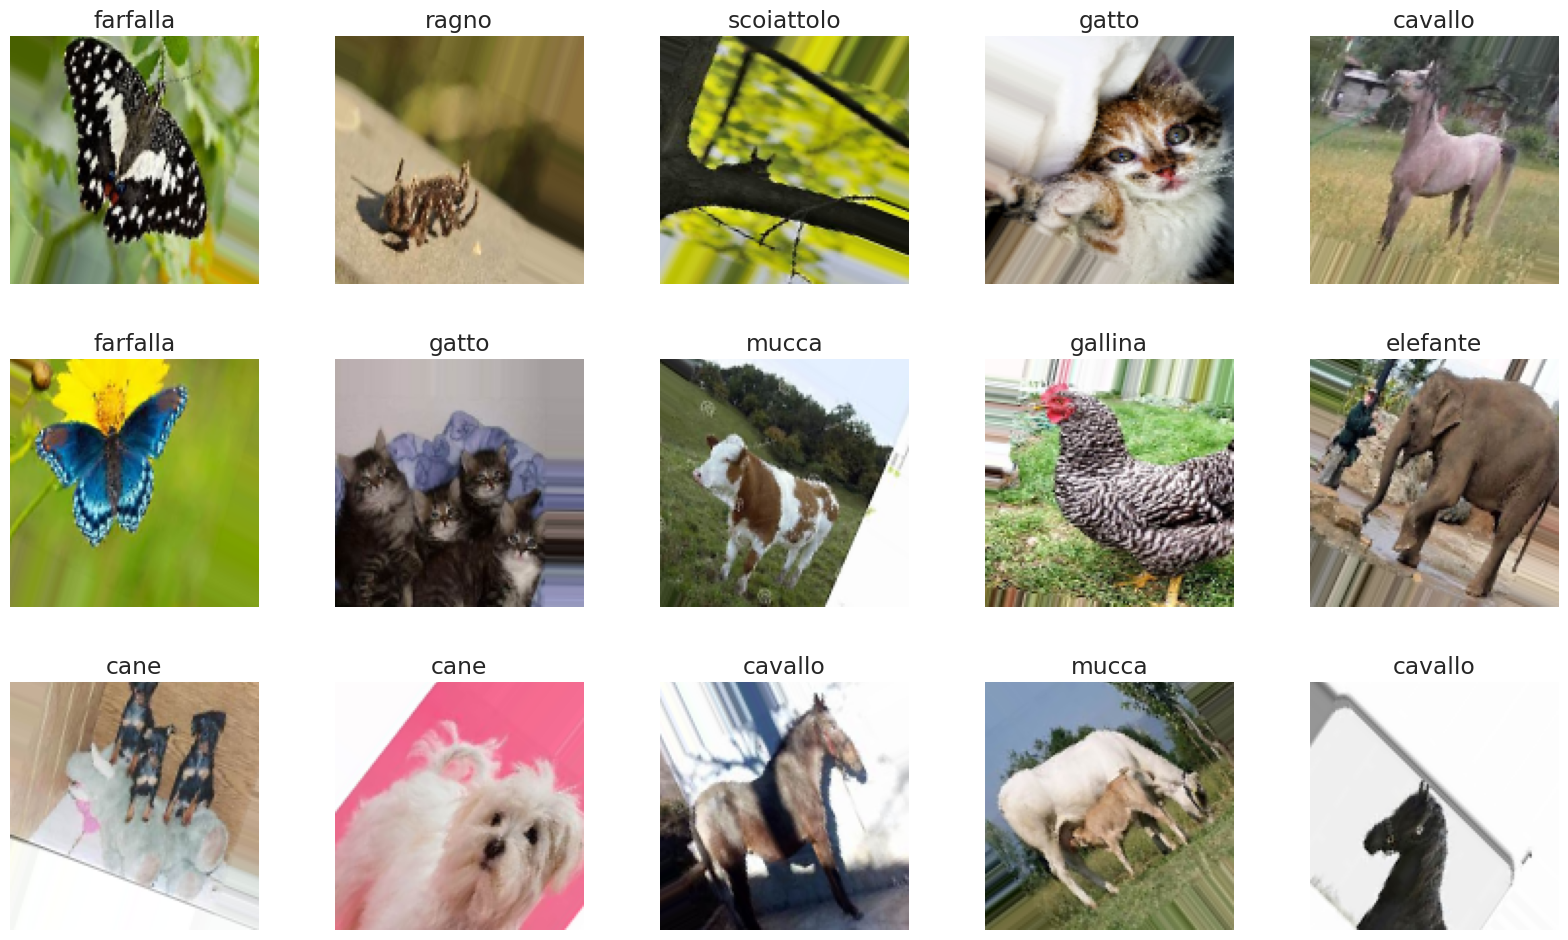

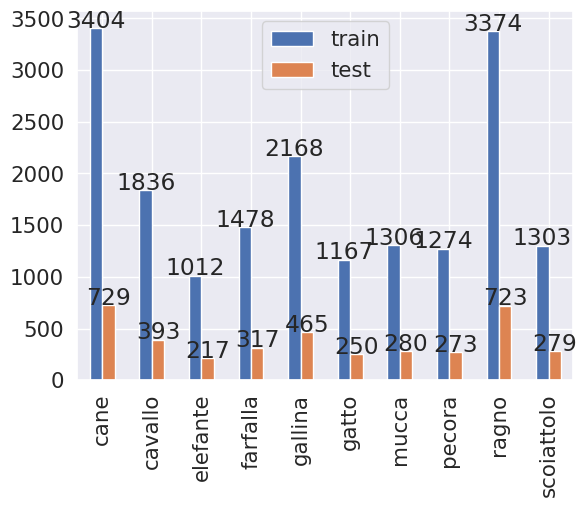

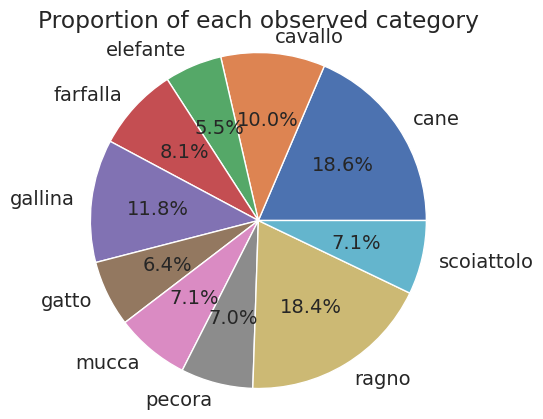

In [6]:
# Visualization
label_dict = train_generator.class_indices
sample_generate = train_generator.__next__()
images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize=(20, 20))

for i in range (15):
	plt.subplot(5, 5, i+1)
	plt.subplots_adjust(hspace=0.3, wspace=0.3)
	plt.imshow(images[i])
	label_index = int(titles[i])
	class_name = list(label_dict.keys())[list(label_dict.values()).index(label_index)]
	plt.title(class_name)
	plt.axis("off")











# Visulization
import pandas as pd

train_labels = train_generator.classes
test_labels = val_generator.classes
class_names = list(train_generator.class_indices.keys())

train_counts = pd.Series(train_labels).value_counts().sort_index()
test_counts = pd.Series(test_labels).value_counts().sort_index()

df = pd.DataFrame({'train': train_counts, 'test': test_counts})
df.index = class_names

ax = df.plot(kind='bar')
for p in ax.patches:
	ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() /2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()










# Visulization
plt.pie(train_counts, explode=(0, 0, 0, 0, 0, 0, 0, 0, 0, 0) , labels=class_names, autopct='%1.1f%%', textprops={'fontsize': 14})
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()





In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [9]:
# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping]
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


573/573 ━━━━━━━━━━━━━━━━━━━━ 124s 200ms/step - accuracy: 0.1737 - loss: 2.5382 - val_accuracy: 0.3179 - val_loss: 2.0171
Epoch 2/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 112s 193ms/step - accuracy: 0.3275 - loss: 1.9906 - val_accuracy: 0.4491 - val_loss: 1.6538
Epoch 3/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 110s 191ms/step - accuracy: 0.4385 - loss: 1.6762 - val_accuracy: 0.5650 - val_loss: 1.3760
Epoch 4/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 105s 181ms/step - accuracy: 0.5367 - loss: 1.4370 - val_accuracy: 0.6508 - val_loss: 1.1685
Epoch 5/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 104s 180ms/step - accuracy: 0.5964 - loss: 1.2744 - val_accuracy: 0.7099 - val_loss: 1.0138
Epoch 6/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 109s 188ms/step - accuracy: 0.6468 - loss: 1.1304 - val_accuracy: 0.7596 - val_loss: 0.8918
Epoch 7/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 136s 177ms/step - accuracy: 0.6875 - loss: 1.0297 - val_accuracy: 0.7883 - val_loss: 0.8007
Epoch 8/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 143s 179ms/step - accuracy: 0.7043 - loss: 0.94

In [10]:
# Calculate F1_Score
def calculate_f1_score(true_positives, false_positives, false_negatives):
    # Calculate Precision
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0

    # Calculate Recall
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    # Calculate F1-Score
    if precision + recall == 0:
        return 0  # Avoid division by zero
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

# Example usage
tp = 50  # True Positives
fp = 10  # False Positives
fn = 15  # False Negatives

f1 = calculate_f1_score(tp, fp, fn)
print(f"F1 Score: {f1:.4f}")



F1 Score: 0.8000


In [11]:

# Step 7: Check for Overfitting
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

overfit_ratio = train_loss / val_loss if val_loss != 0 else float('inf')
print(f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")
print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
print(f"Overfitting Ratio (Train Loss / Validation Loss): {overfit_ratio:.4f}")



Train Accuracy: 0.8503, Validation Accuracy: 0.9022
Train Loss: 0.4544, Validation Loss: 0.3202
Overfitting Ratio (Train Loss / Validation Loss): 1.4191


In [14]:
# Evaluate the model
test_loss, test_acc = model.evaluate(val_generator)
print(f'Test accuracy: {test_acc:.4f}')



123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.9061 - loss: 0.3165
Test accuracy: 0.9022


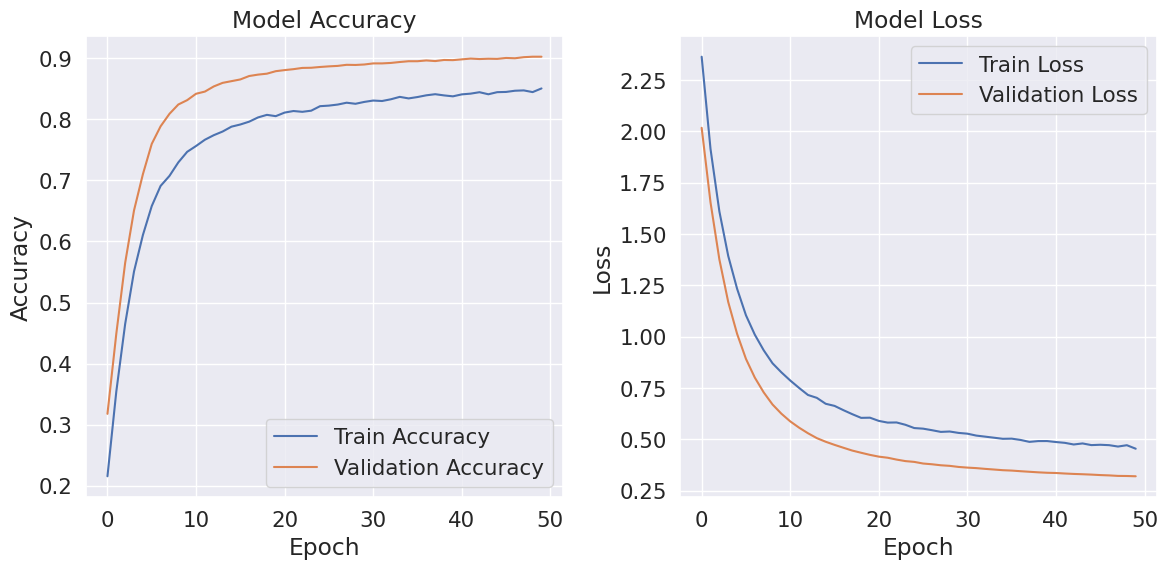

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.631081 to fit



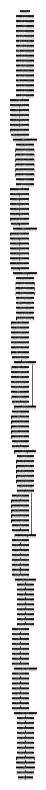

In [13]:
# Step 9: Visualize the Training History
# Accuracy and Loss Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()




# Step 11: Plot the Neural Network Architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


# Display the model architecture image
img = plt.imread('model_architecture.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()



